# Binary classification of images with a convolutional DNN

In [ ]:
!apt-get install unzip

!pip install -U --no-cache-dir \
  tensorflow==1.12.0 \
  tensorflow-gpu==1.12.0 \
  kaggle \
  pillow==3.4.1 \
  scipy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-20ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
    100% |████████████████████████████████| 83.1MB 27.8MB/s ta 0:00:01    36% |███████████▊                    | 30.4MB 52.9MB/s eta 0:00:01    69% |██████████████████████▏         | 57.4MB 49.4MB/s eta 0:00:01    75% |████████████████████████▎       | 63.1MB 48.7MB/s eta 0:00:01    79% |█████████████████████████▍      | 65.9MB 48.6MB/s eta 0:00:01
    100% |████████████████████████████████| 281.7MB 34.8MB/s ta 0:00:01  5% |█▋                              | 14.4MB 31.3MB/s eta 0:00:09    5% |█▉                              | 16.1MB 30.5MB/s eta 0:00:09    6% |██▎                             | 19.6MB 33.2MB/s eta 0:00:08    10% |███▍                            | 30.1MB 29.9MB/s eta 0:00:09    18% |█████▉                          | 50.9MB 30.9MB/s eta 0:00:08    21% |██████▊     

    Uninstalling tensorflow-1.8.0:
      Successfully uninstalled tensorflow-1.8.0
  Found existing installation: tensorflow-gpu 1.8.0
    Uninstalling tensorflow-gpu-1.8.0:
      Successfully uninstalled tensorflow-gpu-1.8.0
  Running setup.py install for kaggle ... done
  Found existing installation: scipy 1.0.0
    Uninstalling scipy-1.0.0:
      Successfully uninstalled scipy-1.0.0


In [3]:
!echo '{"username":"iamkairos","key":"3ff1170a105bc93376c994ae14599a38"}' > ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats -p /content/data

!unzip -n -q /content/data/train.zip -d /content/data
!unzip -n -q /content/data/test1.zip -d /content/data

sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


The data I have for this problem is a large collection of images containing either a cat or a dog. The sizes of these images vary.

Populating the interactive namespace from numpy and matplotlib
Image count: 25000


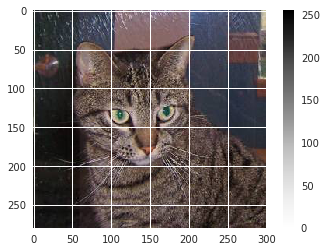

In [1]:
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings("ignore")
%pylab inline

original_data_dir = '/content/data/train'

original_data_count = len([name for name in os.listdir(original_data_dir)])
print("Image count: %s" % original_data_count)

filename = os.path.join(original_data_dir, 'cat.1.jpg')
img = image.load_img(filename)

plt.imshow(img)
plt.colorbar()
plt.show()

I want to make this a small data problem so I'll seperate the training data into three collections. A training set of 1000. A validation set of 500. And, a test set of 500. Sub directories are added for the two class as I'll be using Keras's ImageDataGenerator to read in the images.

In [2]:
import shutil

base_dir = '/content/data/cats-dogs-small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

try:
    os.mkdir(base_dir)

    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    os.mkdir(test_dir)

    os.mkdir(train_cats_dir)
    for i in range(1000):
        src = os.path.join(original_data_dir, 'cat.%s.jpg') % i
        dst = os.path.join(train_cats_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)        
    
    os.mkdir(train_dogs_dir)
    for i in range(1000):
        src = os.path.join(original_data_dir, 'dog.%s.jpg') % i
        dst = os.path.join(train_dogs_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)

    os.mkdir(validation_cats_dir)
    for i in range(1000, 1500):
        src = os.path.join(original_data_dir, 'cat.%s.jpg') % i
        dst = os.path.join(validation_cats_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)

    
    os.mkdir(validation_dogs_dir)
    for i in range(1000, 1500):
        src = os.path.join(original_data_dir, 'dog.%s.jpg') % i
        dst = os.path.join(validation_dogs_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)

    
    os.mkdir(test_cats_dir)
    for i in range(1500, 2000):
        src = os.path.join(original_data_dir, 'cat.%s.jpg') % i
        dst = os.path.join(test_cats_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)

    
    os.mkdir(test_dogs_dir)
    for i in range(1500, 2000):
        src = os.path.join(original_data_dir, 'dog.%s.jpg') % i
        dst = os.path.join(test_dogs_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)
except:
    pass

# check image collections are sized correctly
print('Train cats: %s' % len(os.listdir(train_cats_dir)))
print('Train dogs: %s' % len(os.listdir(train_dogs_dir)))
print('Validate cats: %s' % len(os.listdir(validation_cats_dir)))
print('Validate dogs: %s' % len(os.listdir(validation_dogs_dir)))
print('Test cats: %s' % len(os.listdir(test_cats_dir)))
print('Test dogs: %s' % len(os.listdir(test_dogs_dir)))

Train cats: 1000
Train dogs: 1000
Validate cats: 500
Validate dogs: 500
Test cats: 500
Test dogs: 500


Images in JPEG format really aren't suitable inputs for the model. They need reworked into tensors. Decoding a JPEG into a bitmap gives me a tensor with shape (150, 150, 3).

In [3]:
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


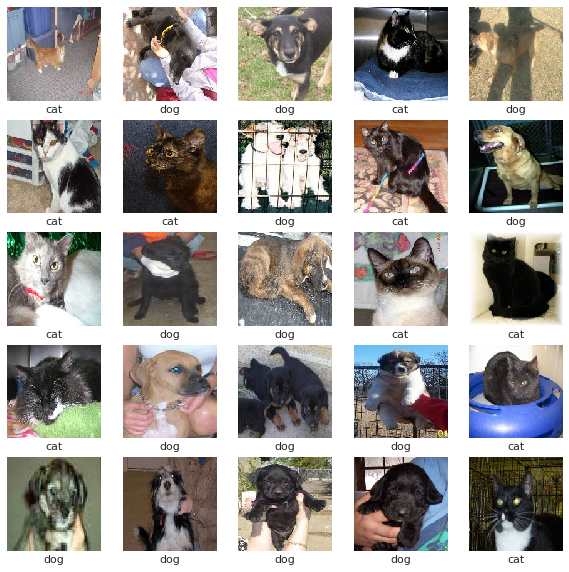

In [4]:
for x_batch, y_batch in train_generator:
    images = x_batch
    labels = list(map(lambda x: 'dog' if x == 1.0 else 'cat', y_batch))
    break

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(labels[i])

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=1e-4),
             metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 51s 506ms/step - loss: 0.6818 - acc: 0.5594 - val_loss: 0.6519 - val_acc: 0.6275
Epoch 2/30
100/100 [==============================] - 29s 286ms/step - loss: 0.6328 - acc: 0.6506 - val_loss: 0.6103 - val_acc: 0.6726
Epoch 3/30
100/100 [==============================] - 30s 295ms/step - loss: 0.5584 - acc: 0.7119 - val_loss: 0.5878 - val_acc: 0.6878
Epoch 4/30
 81/100 [=======================>......] - ETA: 3s - loss: 0.5210 - acc: 0.7419

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

num_epochs = range(1, len(loss) + 1)

plt.plot(num_epochs, loss, 'bo', label='Training loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(num_epochs, acc, 'ro', label='Training accurcy')
plt.plot(num_epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

My model has the characteristics of overfitting. Accuracy on the training data increases Linearly towards 100% while accuracy on the validation data stalls before the 10th epoch. Common methods for avoiding overfitting are dropout and weight decay but in this case I will use data augmentation as its well suited to image recognition problems. This technique creates new images by applying transformations to the input tensors while still keeping its recognisable characteristics. The ImageDataGenerator class has the utility to achieve this given a few extra parameters.

In [ ]:
augmented_train_datagen = ImageDataGenerator(rescale=1./255
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2
                                   horizontal_flip=True)

augmented_train_generator = augmented_train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)